# Autonomous Incident Response System for AWS
---

In this project, we will build an Agentic system to respond to incidents in your AWS accounts. This is a multi-agent system that composes 4 main components: 

1. **Monitoring**: This composes of a tool that enables the agent to get CloudWatch logs from a user account based on their service of interest.

1. **Diagnosis**: This includes diagnosis events that are seen through the monitoring agent. The diagnosis agent will fetch the information from the monitoring agent, use a web search tool to look for remediations, create a report and then use that report in the next resolution agent.

1. **Resolution**: This portion of the solution will be triggered by a diagnosis done from the step before. Once the diagnoses is done with the clear report, then the content of the report is used in the description of the JIRA ticket that the agent creates.

This solution will also contain aspects for observability and tracing but without further ado, let's get right into it.

In [1]:
# import environment variables
import os 
from dotenv import load_dotenv
load_dotenv(override=True)
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")

# Access them in code
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")
os.environ["AWS_REGION"] = os.getenv("AWS_REGION")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

# Set environment variables
os.environ["JIRA_API_TOKEN"] = os.getenv("JIRA_API_TOKEN")
os.environ["JIRA_USERNAME"] = os.getenv("JIRA_USERNAME")
os.environ["JIRA_INSTANCE_URL"] = os.getenv("JIRA_INSTANCE_URL")
os.environ["JIRA_CLOUD"] = "True"
os.environ['PROJECT_KEY'] = os.getenv("PROJECT_KEY")


In [2]:
#import general packages 
import boto3
import logging 
import json
import re
from datetime import datetime, timedelta, timezone
from typing import Annotated, List, Dict, Any, Optional, Union, Literal
from typing_extensions import TypedDict
from langsmith import traceable

#import langgraph relavant packages 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages

#checkpointing for agent memory 
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command

#langchain imports
from langchain_aws.chat_models import ChatBedrockConverse
from langchain_core.tools import BaseTool, tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import JiraAPIWrapper
from langchain_core.messages import BaseMessage
from langchain.tools import Tool
 
#langsmith import 
from langsmith import Client
from langsmith import traceable

from colorama import init, Fore, Style
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage


## Define Formatting per requirement

In [3]:
# Initialize colorama
init()

# Set up a logger for pretty printing
logger = logging.getLogger("aws_monitoring_workflow")
logger.setLevel(logging.INFO)

# Remove any existing handlers to avoid duplicate logs
if logger.hasHandlers():
    for handler in logger.handlers:
        logger.removeHandler(handler)

# Add a new handler with formatting
handler = logging.StreamHandler()
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

def pretty_print_messages(node_output):
    """Format and print only essential messages: tools, AI responses, and agent names."""
    if isinstance(node_output, dict) and "messages" in node_output:
        messages = node_output["messages"]
        for msg in messages:
            # Skip any error-related messages
            if isinstance(msg, dict):  # Handle dict-formatted messages
                role = msg.get("role", "")
                content = msg.get("content", "")
                
                # Only print AI messages
                if role == "assistant" or role == "ai":
                    logger.info(f"{Fore.BLUE}[AI] {content}{Style.RESET_ALL}")
                # Only print tool calls
                elif role == "tool":
                    tool_name = msg.get("name", "tool")
                    logger.info(f"{Fore.YELLOW}[TOOL: {tool_name}] Called{Style.RESET_ALL}")
            
            # Handle LangChain message objects
            elif isinstance(msg, (AIMessage, ToolMessage)):
                if isinstance(msg, AIMessage):
                    logger.info(f"{Fore.BLUE}[AI] {msg.content}{Style.RESET_ALL}")
                elif isinstance(msg, ToolMessage):
                    logger.info(f"{Fore.YELLOW}[TOOL: {msg.name}] Called{Style.RESET_ALL}")
    
    # Print the agent name if available
    if isinstance(node_output, dict) and "agent_name" in node_output:
        logger.info(f"{Fore.MAGENTA}[AGENT: {node_output['agent_name']}]{Style.RESET_ALL}")
    
    # For supervisor or other non-message nodes
    if isinstance(node_output, dict) and "node_type" in node_output:
        logger.info(f"{Fore.CYAN}[NODE: {node_output['node_type']}]{Style.RESET_ALL}")

In [4]:
# define the model constants
AMAZON_NOVA_PRO_MODEL_ID: str = 'us.amazon.nova-pro-v1:0'
AMAZON_NOVA_MICRO_MODEL_ID: str = 'us.amazon.nova-micro-v1:0'
META_LLAMA_3_2_11B_VISION_INSTRUCT: str = 'us.meta.llama3-2-11b-instruct-v1:0'

### State definitions
---

First, we will define the state for our sub agents: for Monitoring, Diagnosis, Remediation and the Supervisor. Since all of these will have similar states, let's go ahead and define a common `incidentState`.

In [5]:
class IncidentState(TypedDict):
    """
    A state in LangGraph is a shared data structure, typically a TypedDict or a Pydantic
    model that represents the current snapshot of your application and allows nodes to communicate and 
    exchange data by reading and writing to it.
    """
    messages: List[BaseMessage]
    alarms: Optional[List[Dict]]
    metrics: Optional[Dict]
    instance_ids: Optional[List[str]]
    diagnosis_report: Optional[str]
    remediation_actions: Optional[List[str]]
    notification_status: Optional[str]
    

With the help of this unified state, this does as follows:

1. **Ensures consistency**: Each agent in this case works with a consistent structure.

1. **Ease of communication**: This facilitates simpler data passing between nodes.

1. **Traceability**: Incident lifecycle remains centralized.

In [6]:
# let's define the LLM that will be used in the monitoring agent
llm = ChatBedrockConverse(
    model_id = AMAZON_NOVA_MICRO_MODEL_ID, 
    temperature = 0.1,
)

logger.info(f"Initialized the LLM: {llm}")

Initialized the LLM: client=<botocore.client.BedrockRuntime object at 0x7f3d0c4f0560> model_id='us.amazon.nova-micro-v1:0' temperature=0.1 aws_access_key_id=SecretStr('**********') aws_secret_access_key=SecretStr('**********') provider='amazon' supports_tool_choice_values=('auto', 'any', 'tool')


#### Define monitoring tools
---

In [7]:

from pydantic import BaseModel
from typing import Optional
# Set up logging
logger = logging.getLogger(__name__)

# Define boto3 and AWS clients
cloudwatch_client = boto3.client('cloudwatch')
cloudtrail_client = boto3.client('cloudtrail')
logs_client = boto3.client('logs')
xray_client = boto3.client('xray')
autoscaling_client = boto3.client('autoscaling')
ec2_client = boto3.client('ec2')
health_client = boto3.client('health')


class FetchLogsInput(BaseModel):
    service_name: str
    days: Optional[int] = 3
    filter_pattern: Optional[str] = ""

@traceable(run_type="tool", name="fetch_cloudwatch_logs_for_service")
def fetch_cloudwatch_logs_for_service(
    service_name: str,
    days: int = 3,
    filter_pattern: str = ""
) -> Dict[str, Any]:
    """
    Fetches CloudWatch logs for a specified service for the given number of days.
    
    Args:
        service_name (str): The name of the service to fetch logs for (e.g., "ec2", "lambda", "rds")
        days (int): Number of days of logs to fetch (default: 3)
        filter_pattern (str): Optional CloudWatch Logs filter pattern
        
    Returns:
        Dictionary with log groups and their recent log events
    """
    try:
        # Map service name to potential log group prefixes
        service_log_prefixes = {
            "ec2": ["/aws/ec2", "/var/log"],
            "lambda": ["/aws/lambda"],
            "rds": ["/aws/rds"],
            "eks": ["/aws/eks"],
            "apigateway": ["/aws/apigateway"],
            "cloudtrail": ["/aws/cloudtrail"],
            "s3": ["/aws/s3", "/aws/s3-access"],
            "vpc": ["/aws/vpc"],
            "waf": ["/aws/waf"],
            "bedrock": ["/bedrockInvocationlogs"], 
            "iam": ['/aws/cloudtrail']
        }
        
        # Default to searching all log groups if service isn't in our mapping
        prefixes = service_log_prefixes.get(service_name.lower(), [""])
        print(f"Fetching logs for the service: {prefixes}")
        
        # Find all log groups for this service
        log_groups = []
        for prefix in prefixes:
            paginator = logs_client.get_paginator('describe_log_groups')
            for page in paginator.paginate(logGroupNamePrefix=prefix):
                log_groups.extend([group['logGroupName'] for group in page['logGroups']])
        
        if not log_groups:
            return {"status": "warning", "message": f"No log groups found for service: {service_name}"}
        
        # Calculate time range
        ##end_time = datetime.utcnow()
        end_time = datetime.now(timezone.utc)
        start_time = end_time - timedelta(days=days)
        
        # Convert to milliseconds since epoch
        start_time_ms = int(start_time.timestamp() * 1000)
        end_time_ms = int(end_time.timestamp() * 1000)
        
        results = {}
        
        # Iterate through log groups and fetch log events
        for log_group in log_groups:
            try:
                # First get log streams
                response = logs_client.describe_log_streams(
                    logGroupName=log_group,
                    orderBy='LastEventTime',
                    descending=True,
                    limit=5  # Get the 5 most recent streams
                )
                print(f"fetching logs for log group {log_group}: {response}")
                streams = response.get('logStreams', [])
                
                if not streams:
                    results[log_group] = {"status": "info", "message": "No log streams found"}
                    continue
                
                group_events = []
                
                # For each stream, get recent log events
                for stream in streams:
                    stream_name = stream['logStreamName']
                    
                    # If filter pattern is provided, use filter_log_events
                    if filter_pattern:
                        filter_response = logs_client.filter_log_events(
                            logGroupName=log_group,
                            logStreamNames=[stream_name],
                            startTime=start_time_ms,
                            endTime=end_time_ms,
                            filterPattern=filter_pattern,
                            limit=100
                        )
                        events = filter_response.get('events', [])
                    else:
                        # Otherwise use get_log_events
                        log_response = logs_client.get_log_events(
                            logGroupName=log_group,
                            logStreamName=stream_name,
                            startTime=start_time_ms,
                            endTime=end_time_ms,
                            limit=100
                        )
                        events = log_response.get('events', [])
                    
                    # Process and add events
                    for event in events:
                        # Convert timestamp to readable format
                        timestamp = datetime.fromtimestamp(event['timestamp'] / 1000)
                        formatted_event = {
                            'timestamp': timestamp.isoformat(),
                            'message': event['message']
                        }
                        group_events.append(formatted_event)
                
                # Sort all events by timestamp (newest first)
                group_events.sort(key=lambda x: x['timestamp'], reverse=True)
                
                results[log_group] = {
                    "status": "success",
                    "events_count": len(group_events),
                    "events": group_events[:100]  # Limit to 100 most recent events
                }
                
            except Exception as e:
                results[log_group] = {"status": "error", "message": str(e)}
        
        return {
            "service": service_name,
            "time_range": f"{start_time.isoformat()} to {end_time.isoformat()}",
            "log_groups_count": len(log_groups),
            "log_groups": results
        }
        
    except Exception as e:
        logger.error(f"Error fetching logs for service {service_name}: {e}")
        return {"status": "error", "message": str(e)}



In [8]:
# Wrap the function into a Tool object so the agent can call it correctly

fetch_logs_tool = Tool.from_function(
    func=fetch_cloudwatch_logs_for_service,
    name="fetch_cloudwatch_logs_for_service",
    description="Fetch CloudWatch logs for a specified AWS service. You can provide days and optional filter pattern.",
    args_schema=FetchLogsInput
)


In [9]:
monitoring_toolkit = [fetch_logs_tool]

In [10]:
# create the monitoring agent.
# We will create a Reason and Act agent from langchain that will be able to break down the problem 
# into specific tasks and will be able to determine which tool to call.
monitoring_system_prompt = """
You are the AWS CloudWatch Logs Monitoring Agent, specialized in retrieving and analyzing log data.

When a user provides a service name (e.g., "iam","EC2", "Lambda", "RDS"), your responsibilities include:

1. Fetch CloudWatch logs for the specified AWS service using the fetch_cloudwatch_logs_for_service tool
2. Analyze the retrieved logs to identify:
   - Error patterns and exceptions
   - Performance issues or slowdowns
   - Security-related events (authorization failures, access denials)
   - Unusual activity or potential anomalies
   - Service outages or degradations

3. When filter patterns are specified, use them to find specific types of log entries
4. Present the logs in a structured, chronological manner
5. Provide a concise summary of key findings, particularly highlighting:
   - Critical errors that need immediate attention
   - Security concerns or suspicious activities
   - Performance bottlenecks
   - Unusual patterns that might indicate problems

When reporting:
1. Start with a high-level summary of what you found
2. Include specific log examples that illustrate important issues
3. Organize information by log group and timestamp
4. Prioritize recent and critical events

Ensure you ask for all required parameters:
- The service name to analyze (required)
- The number of days of logs to examine (optional, default is 3)
- Any specific filter patterns to apply (optional)

Be thorough in your analysis but concise in your reporting.
Mark your work as complete by saying "MONITORING COMPLETE" at the end of your response.
Do not call tools again once this message is produced.
End your reply by saying: `MONITORING COMPLETE` exactly. This is mandatory.
"""
monitoring_agent = create_react_agent(llm, tools=monitoring_toolkit, prompt=monitoring_system_prompt)

### Enable tracing with LangSmith
---

LangSmith is an all-in-one developer platform for every step of the LLM-powered application lifecycle, whether you’re building with LangChain or not.
Debug, collaborate, test, and monitor your LLM applications.

In [13]:
def monitoring_node(state: Dict , config: Optional[Dict] = None) -> Dict:
    """Monitoring agent node to check AWS service status."""
    # Retrieve the current messages from state (defaulting to an empty list if missing)
    messages = state.get("messages", [])
    
    # Invoke the monitoring agent with the current messages
    response = monitoring_agent.invoke({"messages": messages})
    
    # Process the agent's response to extract content and create an AIMessage
    if hasattr(response, "content"):
        content = response.content
        ai_message = response
    elif isinstance(response, str):
        content = response
        ai_message = AIMessage(content=content)
    elif isinstance(response, dict) and "content" in response:
        content = response["content"]
        ai_message = AIMessage(content=content)
    else:
        content = str(response)
        ai_message = AIMessage(content=content)
    
    # Retrieve or initialize the workflow state, and update the monitoring flag
    workflow_state = state.get("workflow", {})
    workflow_state["monitoring_complete"] = "MONITORING COMPLETE" in content
    
    # Optionally, update other fields in your state (e.g., diagnosis_report, alarms) based on content
    
    # Return the updated state with the new message appended and the workflow state updated
    return {
        "messages": messages + [ai_message],
        "workflow": workflow_state,
        "monitoring_complete": workflow_state["monitoring_complete"]  # ← this fixes the routing issue
    }

In [14]:
content = """
I want to check IAM logs for the last 2 days to identify any potential security issues or compliance violations in my AWS account.
"""

# Invoke monitoring agent with the specific request for CloudTrail
monitoring_response = monitoring_agent.invoke({"messages": [HumanMessage(content=content)]})
print(monitoring_response["messages"])

Fetching logs for the service: ['/aws/cloudtrail']
fetching logs for log group /aws/cloudtrail/iam-events: {'logStreams': [{'logStreamName': '946538336216_CloudTrail_us-east-1_3', 'creationTime': 1750106778899, 'firstEventTimestamp': 1750106778828, 'lastEventTimestamp': 1750164993851, 'lastIngestionTime': 1750164993865, 'uploadSequenceToken': '49039859634076750555560659423606178367125615507117645852', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1_3', 'storedBytes': 0}, {'logStreamName': '946538336216_CloudTrail_us-east-1', 'creationTime': 1750106739752, 'firstEventTimestamp': 1750106889395, 'lastEventTimestamp': 1750164870616, 'lastIngestionTime': 1750164870630, 'uploadSequenceToken': '49039859634076586748148598869498582224716308424507465736', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1', 'storedBytes': 0}, {'logStreamName': '

#### Define diagnosis tools
---

In [94]:
# let's define the LLM that will be used in the diagnosis agent. We will be using
# the llama3.2 11b vision instruct model which will be capable of complex reasoning and 
# come up with a diagnosis plan

diagnosis_llm = ChatBedrockConverse(
    model_id = AMAZON_NOVA_PRO_MODEL_ID, 
    temperature = 0.1,
)

In [95]:
#initialize tavily search engine api 
tavily_search  = TavilySearchResults()


# Helper function used inside the tool
def search_each_line(state: Dict) -> str:
    messages = state.get("messages", [])
    if not messages:
        return "No previous messages to review."
    content = ""
    last_msg = messages[-1]
    if isinstance(last_msg, AIMessage):
        content = last_msg.content
    elif isinstance(last_msg, dict) and "content" in last_msg:
        content = last_msg["content"]
    else:
        return "No valid monitoring content to search."

    lines = [line.strip() for line in content.split("\n") if line.strip()]
    aggregated_results = ""
    for line in lines:
        res = tavily_search.invoke({"query": line})
        if isinstance(res, dict) and "content" in res:
            aggregated_results += f"- **{line}**: {res['content']}\n"
        else:
            aggregated_results += f"- **{line}**: No results found.\n"

    return aggregated_results


#### Create Tavily Search Engine tool for the Agent to use 

In [96]:
@tool
def remediation_strategy_from_monitoring(state: Dict) -> Dict:
    """
    Extracts issues from monitoring agent's response and searches for remediation steps.
    This node should be executed after the monitoring_node.
    """
    # Get messages from state
    messages = state.get("messages", [])
    
    # Find the last AIMessage from the monitoring agent
    monitoring_message = None
    for msg in reversed(messages):
        if isinstance(msg, AIMessage):
            monitoring_message = msg
            break
    
    if not monitoring_message:
        # No monitoring message found
        ai_message = AIMessage(content="No monitoring report found to search for remediation steps.")
        return {
            "messages": messages + [ai_message],
            "workflow": state.get("workflow", {})
        }
    
    # Use the enhanced search tool to find remediation steps
    search_results = search_each_line({"messages": [monitoring_message]})
    
    # Create a new message with the search results
    remediation_message = AIMessage(content=f"""
### Remediation Recommendations

Based on the monitoring report, here are potential remediation steps for each identified issue:

{search_results}

Please review these recommendations and implement the appropriate actions to address the security issues.
""")
    
    # Update the workflow state
    workflow_state = state.get("workflow", {})
    workflow_state["remediation_complete"] = True
    
    # Return updated state
    return {
        "messages": messages + [remediation_message],
        "workflow": workflow_state
    }

In [97]:
# Define a list of diagnostic tools used to extract remediation strategies from monitoring data
# This can be extended with more tools as needed
diagnosis_toolkit = [remediation_strategy_from_monitoring]


In [98]:
diagnosis_agent = create_react_agent(
    diagnosis_llm,
    tools=diagnosis_toolkit,
    prompt="""
You are a specialized AWS diagnosis agent focused on identifying and addressing **security and compliance issues** based on log data.

Your responsibilities:
1. Analyze the log-based input you are provided this could include messages, alerts, or summaries from monitoring tools.
2. Identify any known or potential **security misconfigurations**, **compliance violations**, or **anomalous activity**.
3. Do not invent data — rely only on the log content given to you.
4. Create a concise **Security & Compliance Diagnostic Report**. This report should include:
   - Key findings
   - Severity (e.g., High, Medium, Low)
   - Potential risk or affected area
5. If issues are found, use the **web search tool** to look up **remediation strategies** or best practices for resolving those issues.
6. Present any helpful remediation guidance clearly under each issue found.

Always be precise, evidence-based, and avoid assumptions.

ALWAYS END YOUR RESPONSE WITH THE EXACT PHRASE:
DIAGNOSIS COMPLETE
(on a new line, exactly as written).
"""
)

In [99]:
def diagnosis_node(state: Dict, **kwargs) -> Dict:
    """Diagnosis agent node to analyze root causes."""
    messages = state.get("messages", [])
    workflow = state.get("workflow", {
        "current_step": "diagnosis_agent",
        "monitoring_complete": True,
        "diagnosis_complete": False,
        "resolution_complete": False
    })
    
    # Invoke the diagnosis chain with the current messages
    response = diagnosis_agent.invoke({"messages": messages})
    
    # Extract content from the response
    if isinstance(response, dict) and "messages" in response:
        ai_message = response["messages"][-1]
    elif hasattr(response, "content"):
        ai_message = AIMessage(content=response.content)
    elif isinstance(response, str):
        ai_message = AIMessage(content=response)
    else:
        ai_message = AIMessage(content=str(response))
    
    # Make sure the response ends with the completion marker if not already there
    if not ai_message.content.strip().upper().endswith("DIAGNOSIS COMPLETE"):
        ai_message = AIMessage(content=ai_message.content.strip() + "\n\nDIAGNOSIS COMPLETE")
    
    # Update messages with the AI message
    new_messages = messages + [ai_message]
    
    return {
        "messages": new_messages,
        "workflow": workflow
    }

### Test the diagnosis agents
---

Next, after we have defined our monitoring and diagnosis tools and created the agents, we can invoke to test how they work.

In [100]:
content = """ 
Hi, Generate a report on a user trying to break into my AWS account
"""
# Invoke monitoring agent with the given message
diagnosis_response = diagnosis_agent.invoke({"messages": [HumanMessage(content=content)]})
print(diagnosis_response["messages"])

[HumanMessage(content=' \nHi, Generate a report on a user trying to break into my AWS account\n', additional_kwargs={}, response_metadata={}, id='3c29d5f6-af44-4052-b40e-421c6b642329'), AIMessage(content=[{'type': 'text', 'text': '<thinking> To generate a report on a user attempting to break into an AWS account, I need to analyze log data for any signs of unauthorized access attempts. I will look for patterns such as multiple failed login attempts, unusual IP addresses, or attempts to access sensitive resources. Based on these findings, I will create a Security & Compliance Diagnostic Report. </thinking>\n\n'}, {'type': 'tool_use', 'name': 'remediation_strategy_from_monitoring', 'input': {'state': {'event': 'user attempting to break into AWS account'}}, 'id': 'tooluse_hkv-SR2TS32o5rsfppQyfg'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '115f6571-826c-4a64-937c-6091c633cf88', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 17 Jun 2025 12:25:22 GMT',

### Create the resolution tools
---

In this portion of the notebook, we will create a sub agent that will come up with a resolution. In this case, we will create a simple ticket on JIRA that the agent will assign to someone to take a look at.

In [101]:
# use a small model to create and assign issues.
resolution_llm = ChatBedrockConverse(
    model_id = AMAZON_NOVA_MICRO_MODEL_ID,
    temperature=0.1
)

In [102]:
autoscaling_client = boto3.client('autoscaling')
ec2_client = boto3.client('ec2')
lambda_client = boto3.client('lambda')
ecs_client = boto3.client('ecs')

In [103]:
@traceable(run_type="tool", name="Search Tool")
def create_jira_issue(summary: str, description: str, project_key: str = 'AIRT', issue_type: str = "Task", assignee: str = None):
    """
    Creates a new issue in Jira with the specified details.
    """
    try:
        print(f"Creating Jira issue with project_key: {project_key}")
        
        jira = JiraAPIWrapper()
        
        # Create the issue fields dictionary
        issue_fields = {
            "summary": summary,
            "description": description,
            "issuetype": {"name": issue_type},
            "project": {"key": project_key},
        }
        if assignee:
            issue_fields["assignee"] = {"name": assignee}
        
        # Convert dictionary to JSON string
        issue_fields_json = json.dumps(issue_fields)
        print(f"Sending JSON: {issue_fields_json}")
        
        # Pass the JSON string to the issue_create method
        result = jira.issue_create(issue_fields_json)
        print(f"CREATED THE JIRA TICKET! Check your JIRA dashboard.")
        return result
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return {"error": f"Error creating Jira issue: {str(e)}"}
    
resolution_toolkit = [create_jira_issue]

In [104]:
# create agent and equip the agent with  new tool
resolution_agent = create_react_agent(
    resolution_llm,
    tools=resolution_toolkit,
    prompt=f"""You are an agent responsible for creating Jira tickets based on the diagnosis provided.
    When given a diagnosis:
    1. Extract the necessary information to create a Jira ticket.
    2. Use the 'create_jira_issue' tool to create the ticket.
    3. Confirm the creation of the ticket and if the diagnosis or information on 
    any security and compliance vulnerabilities. If there are any such compliance and security concerns from
    the data that you have access to, create a report in the ticket description and steps to fix as well.
    4. Create an in detail task, project key and how to diagnose it within the JIRA ticket.
    the project key is {os.environ['PROJECT_KEY']}"""
)

In [105]:
# Define the resolution node for the workflow
def resolution_node(state: Dict, config: Optional[Dict] = None) -> Dict:
    """Resolution agent node to create JIRA tickets."""
    messages = state["messages"]
    
    # Run the resolution agent
    response = resolution_agent.invoke({"messages": messages})
    
    # Extract content from response based on its structure
    if hasattr(response, "content"):
        content = response.content
    elif isinstance(response, str):
        content = response
    elif isinstance(response, dict) and "content" in response:
        content = response["content"]
    elif hasattr(response, "text"):
        content = response.text
    elif isinstance(response, dict) and "messages" in response:
        # Handle the case where response contains messages
        last_message = response["messages"][-1] if response["messages"] else None
        content = last_message.content if hasattr(last_message, "content") else str(last_message)
    else:
        content = str(response)
    
    # Update workflow state
    workflow_state = state.get("workflow", {})
    workflow_state["resolution_complete"] = "RESOLUTION COMPLETE" in content
    
    # Format response as AI message
    ai_message = AIMessage(content=content)
    
    return {
        "messages": messages + [ai_message],
        "workflow": workflow_state
    }

### Create the supervisor agent and the graph and invoke all agents all together
---


In [106]:
# Define the workflow state
class WorkflowState(TypedDict, total=False):
    current_step: str
    monitoring_complete: bool
    diagnosis_complete: bool
    resolution_complete: bool

# Extended state that includes workflow state
class AWSMonitoringState(MessagesState):
    workflow: WorkflowState

# Supervisor node determines next agent

@traceable
def supervisor_node(state):
    messages = state.get("messages", [])
    workflow = state.get("workflow", {
        "current_step": "monitoring_agent",
        "monitoring_complete": False,
        "diagnosis_complete": False,
        "resolution_complete": False
    })
    
    # Check last message for completion markers
    if messages and len(messages) >= 1 and isinstance(messages[-1], AIMessage):
        content = messages[-1].content
        if "MONITORING COMPLETE" in content.upper():
            workflow["monitoring_complete"] = True
            workflow["current_step"] = "diagnosis_agent"
        elif "DIAGNOSIS COMPLETE" in content.upper():
            workflow["diagnosis_complete"] = True
            workflow["current_step"] = "resolution_agent"
        elif "RESOLUTION COMPLETE" in content.upper():
            workflow["resolution_complete"] = True
            workflow["current_step"] = "END"
    
    # If resolution is happening and the agent has run at least once, consider it complete
    if workflow["current_step"] == "resolution_agent" and workflow["diagnosis_complete"] and len(messages) >= 5:
        workflow["resolution_complete"] = True
        workflow["current_step"] = "END"
    
    # Determine the next step based on workflow state
    next_step = workflow["current_step"]
    
    print(f"Supervisor routing to: {next_step}")
    print(f"Workflow state: {workflow}")
    
    if next_step == "END":
        return {"next": END, "workflow": workflow}
    return {"next": next_step, "workflow": workflow}

# Create the graph
workflow_graph = StateGraph(AWSMonitoringState)

# Add nodes
workflow_graph.add_node("supervisor", supervisor_node)
workflow_graph.add_node("monitoring_agent", monitoring_node)
workflow_graph.add_node("diagnosis_agent", diagnosis_node)
workflow_graph.add_node("resolution_agent", resolution_node)

# Set the entrypoint
workflow_graph.set_entry_point("supervisor")

# Add conditional edges from supervisor
workflow_graph.add_conditional_edges(
    "supervisor",
    lambda state: state["next"], 
    {
        "monitoring_agent": "monitoring_agent",
        "diagnosis_agent": "diagnosis_agent",
        "resolution_agent": "resolution_agent",
        END: END
    }
)

# Add edges from agents back to supervisor
workflow_graph.add_edge("monitoring_agent", "supervisor")
workflow_graph.add_edge("diagnosis_agent", "supervisor")
workflow_graph.add_edge("resolution_agent", "supervisor")
aws_monitoring_workflow = workflow_graph.compile()

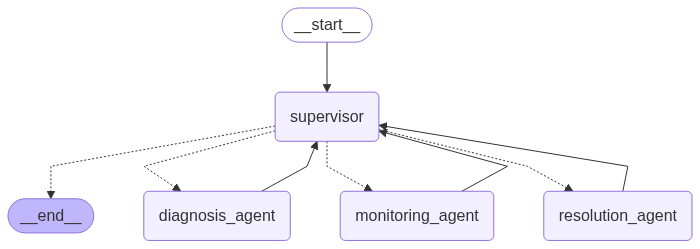

In [107]:
from IPython.display import display, Image

display(Image(aws_monitoring_workflow.get_graph().draw_mermaid_png()))

### Invoke the graph

In [108]:
txt = """
I want to check if my account has any security or compliance vulnerabilities. For this, 
I want to discover my iam logs for the past, let's say a week and then diagnose it. Any
help would be great!
"""

# Run the workflow
events = aws_monitoring_workflow.stream(
    {"messages": [{"role": "user", "content": txt}]}, 
    {"recursion_limit": 10}
)

# Log and save the events
logger.info(f"{Fore.MAGENTA}=== STARTING AWS MONITORING WORKFLOW ==={Style.RESET_ALL}")

with open("output.txt", "a") as file:
    from datetime import datetime
    
    if events is not None:
        for event in events:
            # Log the node being executed
            for node_name, node_output in event.items():
                logger.info(f"{Fore.CYAN}[NODE: {node_name}]{Style.RESET_ALL}")
                
                # Special handling for supervisor node
                if node_name == "supervisor":
                    workflow_state = node_output.get("workflow", {})
                    logger.info(f"{Fore.MAGENTA}Workflow State: {workflow_state}{Style.RESET_ALL}")
                else:
                    # For agent nodes, pretty print the messages
                    pretty_print_messages(node_output)
                
                # Save to file
                file.write(f"{datetime.now()} - {node_name}: {str(node_output)}\n")
    else:
        error_msg = "Workflow events stream is None"
        logger.error(error_msg)
        file.write(f"{datetime.now()} - ERROR: {error_msg}\n")

logger.info(f"{Fore.MAGENTA}=== WORKFLOW COMPLETE ==={Style.RESET_ALL}")

Failed to get inputs for (state): got an unexpected keyword argument 'config'


Supervisor routing to: monitoring_agent
Workflow state: {'current_step': 'monitoring_agent', 'monitoring_complete': False, 'diagnosis_complete': False, 'resolution_complete': False}
Fetching logs for the service: ['/aws/cloudtrail']
fetching logs for log group /aws/cloudtrail/iam-events: {'logStreams': [{'logStreamName': '946538336216_CloudTrail_us-east-1_3', 'creationTime': 1750106778899, 'firstEventTimestamp': 1750106778828, 'lastEventTimestamp': 1750158912551, 'lastIngestionTime': 1750158912595, 'uploadSequenceToken': '49039859634068667161226731347941268542724002964696557450', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1_3', 'storedBytes': 0}, {'logStreamName': '946538336216_CloudTrail_us-east-1_4', 'creationTime': 1750106798128, 'firstEventTimestamp': 1750106798088, 'lastEventTimestamp': 1750134790974, 'lastIngestionTime': 1750134790997, 'uploadSequenceToken': '49039859634036604057862061912791264914232

Failed to get inputs for (state): got an unexpected keyword argument 'config'


Supervisor routing to: diagnosis_agent
Workflow state: {'current_step': 'diagnosis_agent', 'monitoring_complete': True, 'diagnosis_complete': False, 'resolution_complete': False}


Failed to get inputs for (state): got an unexpected keyword argument 'config'


Supervisor routing to: resolution_agent
Workflow state: {'current_step': 'resolution_agent', 'monitoring_complete': True, 'diagnosis_complete': True, 'resolution_complete': False}


ModelErrorException: An error occurred (ModelErrorException) when calling the Converse operation: Model produced invalid sequence as part of ToolUse. Please refer to the model tool use troubleshooting guide.

### Create a Streamlit UI
---

In [27]:
import logging
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime
from colorama import Fore, Style

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def pretty_print_messages(node_output):
    """Pretty print the messages to the logger (for internal logging)."""
    for key, value in node_output.items():
        logger.info(f"    {key}: {value}")

# Create UI components
heading = widgets.HTML("<h1 style='text-align:center;'>AWS Security & Compliance Chatbot</h1><hr>")
chat_output = widgets.Output(layout={'border': '1px solid black', 'height': '300px', 'overflow_y': 'auto'})

# Create text input and send button for the bottom input area
text_input = widgets.Text(
    value="""I want to check if my account has any security or compliance vulnerabilities. For this, 
I want to discover my iam logs for the past, let's say a week and then diagnose it. Any
help would be great!""",
    placeholder="Type your message here...",
    description="",
    disabled=False,
    layout=widgets.Layout(width="80%")
)
send_button = widgets.Button(
    description="Send",
    button_style="success",
    tooltip="Click to send your query",
    icon="paper-plane",
    layout=widgets.Layout(width="20%")
)

def on_send_button_clicked(b):
    # Get user's message from the input box.
    user_msg = text_input.value.strip()
    if not user_msg:
        return  # Ignore empty messages

    # Display the user's query in the chat log.
    with chat_output:
        print(f"\nUser: {user_msg}\n")
    
    # Prepare the payload as required by your workflow.
    params = {"messages": [{"role": "user", "content": user_msg}]}
    extra_params = {"recursion_limit": 10}
    
    # Log the start of the workflow invocation.
    logger.info(f"{Fore.MAGENTA}=== STARTING AWS MONITORING WORKFLOW ==={Style.RESET_ALL}")
    
    # Run the workflow.
    events = aws_monitoring_workflow.stream(params, extra_params)
    
    # Log events and save them to file.
    with open("output.txt", "a") as file:
        if events is not None:
            for event in events:
                for node_name, node_output in event.items():
                    logger.info(f"{Fore.CYAN}[NODE: {node_name}]{Style.RESET_ALL}")
                    
                    # Display node output in the chat UI.
                    with chat_output:
                        if node_name == "supervisor":
                            workflow_state = node_output.get("workflow", {})
                            print(f"[{node_name}] Workflow State: {workflow_state}")
                        else:
                            for key, value in node_output.items():
                                print(f"[{node_name}] {key}: {value}")
                    
                    # Save the event details to a file with a timestamp.
                    file.write(f"{datetime.now()} - {node_name}: {str(node_output)}\n")
        else:
            error_msg = "Workflow events stream is None"
            logger.error(error_msg)
            with chat_output:
                print(error_msg)
            file.write(f"{datetime.now()} - ERROR: {error_msg}\n")
    
    logger.info(f"{Fore.MAGENTA}=== WORKFLOW COMPLETE ==={Style.RESET_ALL}")
    
    # Clear the input for the next query.
    text_input.value = ""

# Bind the send button to the callback.
send_button.on_click(on_send_button_clicked)

# Arrange the UI in a typical chat layout:
# 1. A header at the top.
# 2. The chat output in the middle.
# 3. An input area (text input and send button) at the bottom.
input_area = widgets.HBox([text_input, send_button])
ui = widgets.VBox([heading, chat_output, input_area])
display(ui)

INFO:__main__:=== STARTING AWS MONITORING WORKFLOW ===


Supervisor routing to: monitoring_agent
Workflow state: {'current_step': 'monitoring_agent', 'monitoring_complete': False, 'diagnosis_complete': False, 'resolution_complete': False}


INFO:__main__:[NODE: supervisor]
INFO:langchain_aws.chat_models.bedrock_converse:Using Bedrock Converse API to generate response


Fetching logs for the service: ['/aws/dummy-security-logs']


INFO:langchain_aws.chat_models.bedrock_converse:Using Bedrock Converse API to generate response
INFO:__main__:[NODE: monitoring_agent]


Supervisor routing to: diagnosis_agent
Workflow state: {'current_step': 'diagnosis_agent', 'monitoring_complete': True, 'diagnosis_complete': False, 'resolution_complete': False}


INFO:__main__:[NODE: supervisor]
INFO:langchain_aws.chat_models.bedrock_converse:Using Bedrock Converse API to generate response
INFO:__main__:[NODE: diagnosis_agent]


Supervisor routing to: resolution_agent
Workflow state: {'current_step': 'resolution_agent', 'monitoring_complete': True, 'diagnosis_complete': True, 'resolution_complete': False}


INFO:__main__:[NODE: supervisor]
INFO:langchain_aws.chat_models.bedrock_converse:Using Bedrock Converse API to generate response
INFO:__main__:[NODE: resolution_agent]


Supervisor routing to: resolution_agent
Workflow state: {'current_step': 'resolution_agent', 'monitoring_complete': True, 'diagnosis_complete': True, 'resolution_complete': False}


INFO:__main__:[NODE: supervisor]
INFO:langchain_aws.chat_models.bedrock_converse:Using Bedrock Converse API to generate response
INFO:__main__:[NODE: resolution_agent]


Supervisor routing to: END
Workflow state: {'current_step': 'END', 'monitoring_complete': True, 'diagnosis_complete': True, 'resolution_complete': True}


INFO:__main__:[NODE: supervisor]
INFO:__main__:=== WORKFLOW COMPLETE ===
